<a href="https://colab.research.google.com/github/pragneshrana/DeepLearning/blob/master/DeepCNN/SqeezNet_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [3]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  #resizing image
    transforms.ToTensor(),  #converting to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #(mean,SD)(3 channel RGB)
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [4]:
trainset = torchvision.datasets.STL10(root='./data', split='train', 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.STL10(root='./data', split='test', 
                                        download=True, 
                                        transform=transform_test)

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes = 10

## SqueezNet Model

In [19]:
stl10 = models.squeezenet1_0(pretrained=True)

In [20]:
print(stl10)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [21]:
for param in stl10.parameters():
    param.requires_grad = False

In [24]:
in_features = stl10.classifier
stl10.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(512, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

In [25]:
for param in stl10.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512, 1, 1])
torch.Size([10])


In [26]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [27]:
stl10 = stl10.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(stl10.parameters(), lr=0.01)

In [36]:
def evaluation_stl10(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 0.50
Iteration: 0/3125, Loss: 0.50
Min loss 0.43
Min loss 0.35
Iteration: 100/3125, Loss: 1.02
Min loss 0.32
Iteration: 200/3125, Loss: 0.72
Min loss 0.24
Iteration: 300/3125, Loss: 0.76
Epoch: 0/1, Test acc: 68.99, Train acc: 71.16


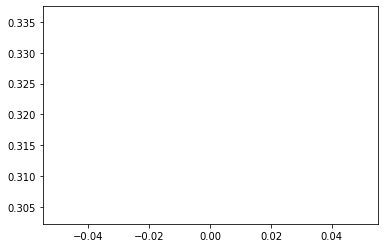

In [37]:
import copy 

loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = stl10(inputs)
        loss = loss_fn(outputs, labels) 
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(stl10.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_stl10(testloader, stl10), 
        evaluation_stl10(trainloader, stl10)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [40]:
stl10.load_state_dict(best_model)
print(evaluation_stl10(trainloader, stl10), evaluation_stl10(testloader, stl10))

71.74 70.4125
